In [1]:
import numpy as np
import scipy as sp
import torch
import matplotlib.pyplot as plt

plt.rcParams['axes.facecolor'] = 'white'


import sys
sys.path.append('conditional_gan/')

import datetime
import warnings


In [2]:
warnings.filterwarnings('ignore')

In [3]:
import torch.utils.data
import os.path
import random
import torchvision.transforms as transforms
import numpy as np
from numpy import inf
import matplotlib.gridspec as gridspec
from skimage.transform import rescale, resize, downscale_local_mean
from matplotlib.pyplot import figure
from networks import define_G


In [46]:
test_data_input = dict(np.load('datasets/livneh/testA.npz'))
test_data_ouput = dict(np.load('datasets/livneh/testB.npz'))
starting_day = datetime.date(1900, 1, 1) + datetime.timedelta(days = 37620 + 4018 - 804)

model_path = "conditional_gan/SavedModels/latest"
#model_path = "conditional_gan/checkpoints/ablation/cGANlossLambdaSnow0/latest"

data_A = test_data_input['data']
data_B = test_data_ouput['data']

def take_two_weeks(input_data, start_date):
    return input_data[start_date:start_date + 14, :, :, :]

model = define_G(6, 1, 32, 'instance', 'resnet', False, [0])
model.load_state_dict(torch.load(model_path)['netG_A_B'])
model.eval()

#normalizing data
def arr_to_input(arr):
    arr = np.nan_to_num(arr)
    if arr.ndim == 3:
        arr = np.expand_dims(arr, axis=2)
    means = np.nanmean(arr, axis=(0,1,2))
    # scale and shift to [-1,1]
    arr = -1 + 2 * (arr - arr.min((1,2))[:, np.newaxis,np.newaxis]) / (arr.max((1,2))[:, np.newaxis,np.newaxis] - arr.min((1,2))[:, np.newaxis,np.newaxis])
    arr[np.isnan(arr)] = -1; arr[arr == inf] = -1; arr[arr == -inf] = -1
    if 64 is not None:
        new_arr = []
        #print "Resizing data to %d" % 64
        for x in arr:
            new_arr.append(resize(x, (64,64)))
        arr = np.stack(new_arr)
    # convert data from b,0,1,c to b,c,0,1
    arr = np.transpose(arr, (0,3,1,2))
    
    return arr.astype('float32')



In [47]:
def take_n_samples_random(data_A, data_B, n):
    image_indices = np.random.choice(804, n)
    return data_A[image_indices, :,:, :], data_B[image_indices, :,:, :]

data_A, data_B = take_n_samples_random(data_A, data_B, 200)

model_output = model(torch.from_numpy(arr_to_input(data_A)).cuda()).cpu().detach().numpy()
print("RMSE: ", np.sqrt(np.mean((arr_to_input(data_B) - model_output)**2)))
print("L1 ERROR :", np.mean(np.abs((arr_to_input(data_B) - model_output))))
print("MAPE :", 100*np.mean(np.abs((arr_to_input(data_B) - model_output)/arr_to_input(data_B))))
print("SMAPE :", 100*np.mean(np.abs((arr_to_input(data_B) - model_output))/(0.5*(np.abs(arr_to_input(data_B)) + np.abs(model_output)))))
print("MAAPE :", 100*np.mean(np.arctan(np.abs((arr_to_input(data_B) - model_output)/arr_to_input(data_B)))))





RMSE:  0.06375559
L1 ERROR : 0.012959387
MAPE : 7.627023011445999
SMAPE : 2.6711465790867805
MAAPE : 2.1113907918334007


In [50]:
rmse = []
l1 = []
mape = []
smape = []
maape = []


for i in range(0, 100):
    print(i)
    data_A = test_data_input['data']
    data_B = test_data_ouput['data']
    data_A, data_B = take_n_samples_random(data_A, data_B, 200)

    model_output = model(torch.from_numpy(arr_to_input(data_A)).cuda()).cpu().detach().numpy()
    rmse.append(np.sqrt(np.mean((arr_to_input(data_B) - model_output)**2)))
    l1.append(np.mean(np.abs((arr_to_input(data_B) - model_output))))
    mape.append(100*np.mean(np.abs((arr_to_input(data_B) - model_output)/arr_to_input(data_B))))
    smape.append(100*np.mean(np.abs((arr_to_input(data_B) - model_output))/(0.5*(np.abs(arr_to_input(data_B)) + np.abs(model_output)))))
    maape.append(100*np.mean(np.arctan(np.abs((arr_to_input(data_B) - model_output)/arr_to_input(data_B)))))

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


In [55]:
np.mean(rmse)

0.06616183

In [57]:
np.mean(l1)

0.014421514

In [58]:
np.mean(mape)

47.75804693251848

In [59]:
np.mean(smape)

3.02325795032084

In [60]:
np.mean(maape)

2.349314237013459

In [6]:
starting_day

datetime.date(2011, 10, 20)

In [8]:
test_data_input.keys()

dict_keys(['data', 'variables', 'metadata'])

In [9]:
test_data_input['data'].shape

(804, 64, 64, 6)

In [10]:
test_data_ouput['data'].shape

(804, 64, 64, 1)

In [11]:
data_A = test_data_input['data']
data_B = test_data_ouput['data']

In [12]:
test_data_ouput['metadata']

array([], dtype=float64)

In [13]:
def take_two_weeks(input_data, start_date):
    return input_data[start_date:start_date + 14, :, :, :]

In [14]:
take_two_weeks(test_data_ouput['data'], 10).shape

(14, 64, 64, 1)

In [15]:
from networks import define_G

In [16]:
model = define_G(6, 1, 32, 'instance', 'resnet', False, [0])
model

ResnetGenerator(
  (model): Sequential(
    (0): ReflectionPad2d((3, 3, 3, 3))
    (1): Conv2d(6, 32, kernel_size=(7, 7), stride=(1, 1))
    (2): InstanceNorm()
    (3): ReLU(inplace)
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): InstanceNorm()
    (6): ReLU(inplace)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (8): InstanceNorm()
    (9): ReLU(inplace)
    (10): ResnetBlock(
      (conv_block): Sequential(
        (0): ReflectionPad2d((1, 1, 1, 1))
        (1): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1))
        (2): ReLU(inplace)
        (3): ReflectionPad2d((1, 1, 1, 1))
        (4): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1))
        (5): InstanceNorm()
      )
      (relu): ReLU(inplace)
    )
    (11): ResnetBlock(
      (conv_block): Sequential(
        (0): ReflectionPad2d((1, 1, 1, 1))
        (1): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1))
        (2): ReLU(inplace)
        (3): 

In [17]:
model.load_state_dict(torch.load(model_path)['netG_A_B'])
model.eval()

ResnetGenerator(
  (model): Sequential(
    (0): ReflectionPad2d((3, 3, 3, 3))
    (1): Conv2d(6, 32, kernel_size=(7, 7), stride=(1, 1))
    (2): InstanceNorm()
    (3): ReLU(inplace)
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): InstanceNorm()
    (6): ReLU(inplace)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (8): InstanceNorm()
    (9): ReLU(inplace)
    (10): ResnetBlock(
      (conv_block): Sequential(
        (0): ReflectionPad2d((1, 1, 1, 1))
        (1): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1))
        (2): ReLU(inplace)
        (3): ReflectionPad2d((1, 1, 1, 1))
        (4): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1))
        (5): InstanceNorm()
      )
      (relu): ReLU(inplace)
    )
    (11): ResnetBlock(
      (conv_block): Sequential(
        (0): ReflectionPad2d((1, 1, 1, 1))
        (1): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1))
        (2): ReLU(inplace)
        (3): 

In [18]:
torch.histc(torch.from_numpy(test_data_ouput['data'][1,:,:,:]))

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.], dtype=torch.float64)

In [19]:
#plt.imshow(model(torch.from_numpy(arr_to_input(data_A[150:151, :, :, :])).cuda()).cpu().detach().numpy()[0,0,:,:])

In [20]:
figure(num=None, figsize=(1, 1), dpi=80, facecolor='w', edgecolor='k')

<Figure size 80x80 with 0 Axes>

<Figure size 80x80 with 0 Axes>

In [22]:
temp = arr_to_input(data_A[150:151,:,:,:])

In [23]:
temp[0,1].shape

(64, 64)

In [24]:
temp1 = np.concatenate((temp[0,0], temp[0,1], temp[0,2]))

In [25]:
temp2 = np.concatenate((temp[0,3], temp[0,4], temp[0,5]))

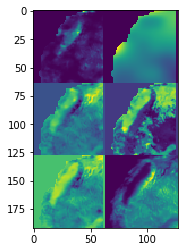

In [26]:
plt.imshow(np.concatenate((temp1, temp2), axis = 1))

In [27]:
temp = arr_to_input(data_B[150:151,:,:,:])

In [28]:
temp.shape

(1, 1, 64, 64)

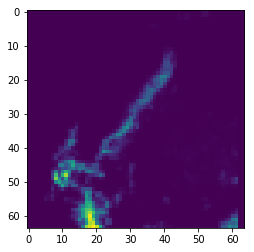

In [29]:
plt.imshow(temp[0,0, :,:])

In [30]:
def hist_kl_div(tenA, tenB, numbins):
    min_elem = min(torch.min(tenA).item(), torch.min(tenB).item())
    max_elem = max(torch.max(tenA).item(), torch.max(tenB).item())
    #print(min_elem, max_elem)
    histA = torch.histc(tenA.cpu(), numbins, min_elem, max_elem)
    histB = torch.histc(tenB.cpu(), numbins, min_elem, max_elem)
    eps = 1e-4
    histA = (histA+eps)*1.0/torch.sum(histA)
    histB = (histB+eps)*1.0/torch.sum(histB)
    return torch.sum(histA * (torch.log(histA) - torch.log(histB)))

In [31]:
def plot_hist_diffs(start_date, inputA, inputB, nan_mask):
    fake_B = model(torch.from_numpy(arr_to_input(take_two_weeks(inputA, start_date))[:,:,:,:]).cuda()).cpu()
    real_B = torch.from_numpy(arr_to_input(take_two_weeks(inputB, start_date)))
    curr_day = 0
    #print(real_B.shape)
    mask = np.ravel(np.tile(nan_mask, (real_B.shape[0], 1, 1, 1)))
    #for images in zip(real_B, fake_B):
    real_im = np.ravel(real_B.detach().numpy())*mask
    fake_im = np.ravel(fake_B.detach().numpy())*mask
    
    real_im = real_im[~np.isnan(real_im)]
    fake_im = fake_im[~np.isnan(fake_im)]
    
    fig, ax = plt.subplots(figsize=(20, 10))
    ax.hist(real_im - fake_im, 1000, None, ec='blue',  histtype='step', label='diffs')
    ax.legend(loc='upper left')
    title = "Histogram of data binned from " + str(starting_day + datetime.timedelta(days = start_date)) + " to " + str(starting_day + datetime.timedelta(days = start_date + 14))
    ax.set_title(title)

In [32]:
def plot_histograms(start_date, inputA, inputB, nan_mask):
    fake_B = model(torch.from_numpy(arr_to_input(take_two_weeks(inputA, start_date))[:,:,:,:]).cuda()).cpu()
    real_B = torch.from_numpy(arr_to_input(take_two_weeks(inputB, start_date)))
    curr_day = 0
    #print(real_B.shape)
    mask = np.ravel(np.tile(nan_mask, (real_B.shape[0], 1, 1, 1)))
    #for images in zip(real_B, fake_B):
    real_im = np.ravel(real_B.detach().numpy())*mask
    fake_im = np.ravel(fake_B.detach().numpy())*mask
    
    real_im = real_im[~np.isnan(real_im)]
    fake_im = fake_im[~np.isnan(fake_im)]
    
    
    
    
    
    fig, ax = plt.subplots(figsize=(20, 10))
    ax.hist(real_im, 1000, None, ec='blue',  histtype='step', label='Real Data')
    ax.hist(fake_im, 1000, None, ec='green',  histtype='step', label='Generated Data')
    ax.legend(loc='upper left')
    title = "Histogram of data binned from " + str(starting_day + datetime.timedelta(days = start_date)) + " to " + str(starting_day + datetime.timedelta(days = start_date + 14))
    ax.set_title(title)
            
#     fig, ax = plt.subplots(nrows=14, ncols=1, figsize=(15, 45))
#     divergences = []
#     for row in ax:
#         colors = ['blue', 'lime']
#         real_im = np.ravel(real_B[curr_day, :,:,:].detach().numpy())
#         fake_im = np.ravel(fake_B[curr_day, :,:,:].detach().numpy())
#         common_params = dict(bins=100, range=(min(np.min(real_im), np.min(fake_im)), max(np.max(real_im), np.max(fake_im))), normed=True, color = colors, label = ['real', 'fake'])
#         #col.title = 'Histograms of Real vs Fake data on day ' + str(start_date + curr_day)
#         row.hist((real_im, fake_im), **common_params)
#         row.legend(prop={'size': 10})

        
#         divergences.append(hist_kl_div(real_B[curr_day, :,:,:].detach(), fake_B[curr_day, :,:,:].detach(), 100))
#         curr_day +=1
    #return divergences

In [33]:
mask = np.load("OceanMask.npy")
mask = resize(mask.astype(np.float), (64,64))
mask[mask == 1] = np.nan
mask = mask + 1

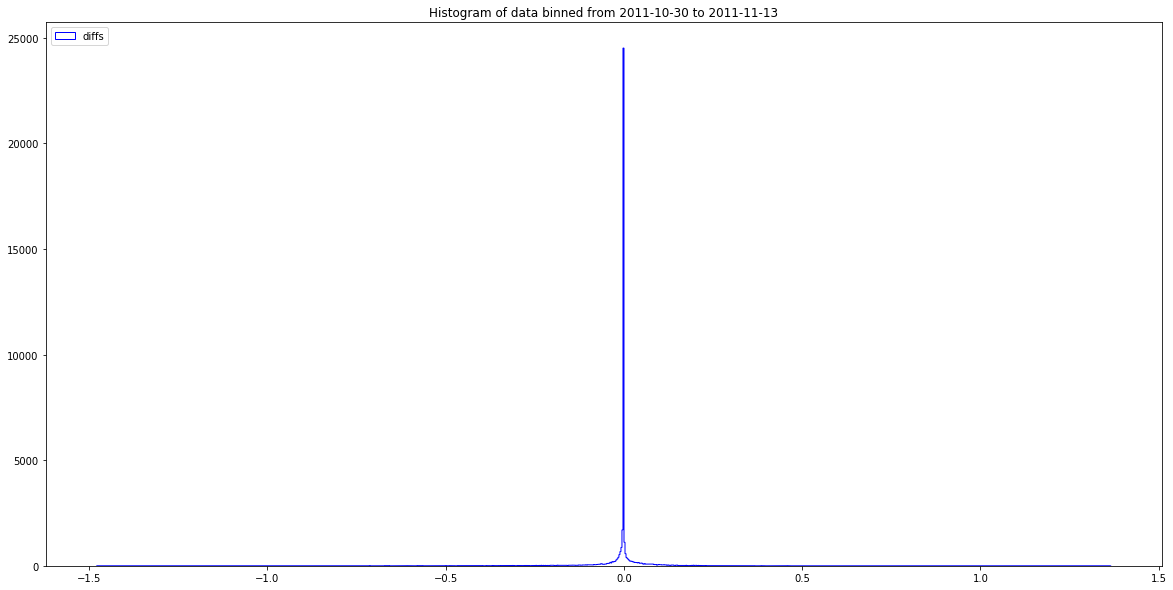

In [34]:
plot_hist_diffs(10, data_A, data_B, mask)

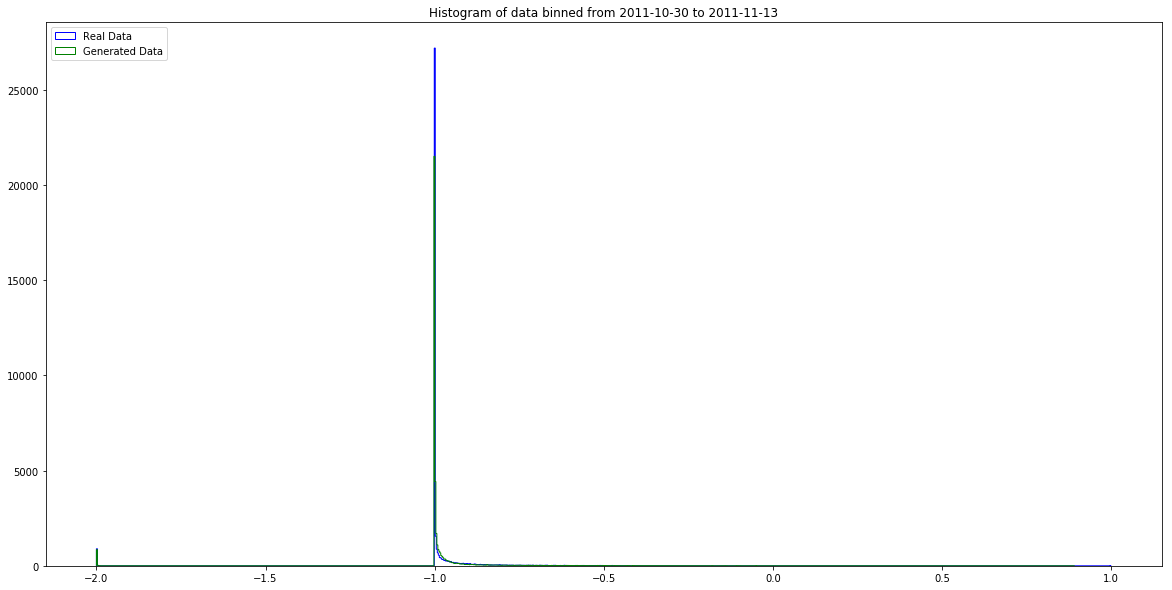

In [34]:
plot_histograms(10, data_A, data_B, mask)

In [35]:
def pearson_coeff(start_date, inputA, inputB):
    fakeB = model(torch.from_numpy(arr_to_input(take_two_weeks(inputA, start_date))[:,:,:,:]).cuda()).detach().cpu().numpy()
    realB = torch.from_numpy(arr_to_input(take_two_weeks(inputB, start_date))).numpy()
    
    xbar = np.mean(fakeB, axis=0)
    ybar = np.mean(realB, axis=0)
    xSTDev = np.std(fakeB, axis=0)
    ySTDev = np.std(realB, axis=0)
    r = np.mean(((fakeB - xbar)/(xSTDev)) * ((realB - ybar)/(ySTDev)), axis = 0)
    return r
    

In [36]:
def kge(start_date, inputA, inputB):
    fakeB = model(torch.from_numpy(arr_to_input(take_two_weeks(inputA, start_date))[:,:,:,:]).cuda()).detach().cpu().numpy()
    realB = torch.from_numpy(arr_to_input(take_two_weeks(inputB, start_date))).numpy()
    
    xbar = np.mean(fakeB, axis=0)
    ybar = np.mean(realB, axis=0)
    xSTDev = np.std(fakeB, axis=0)
    ySTDev = np.std(realB, axis=0)
    r = np.mean(((fakeB - xbar)/(xSTDev)) * ((realB - ybar)/(ySTDev)), axis = 0)
    
    KGE = 1 - np.sqrt((r - 1)**2 + (xbar/ybar - 1)**2 + (xSTDev/ySTDev - 1)**2)
    return KGE

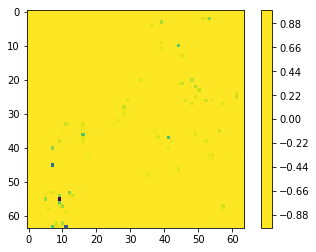

In [37]:
ax = plt.imshow(np.nan_to_num(kge(400, data_A, data_B))[0,:,:])
plt.colorbar(ax, boundaries=np.linspace(-1,1,101))


In [38]:
#Making better looking histograms

In [ ]:
def plot_hist_diffs(start_date, inputA, inputB, nan_mask):
    fake_B = model(torch.from_numpy(arr_to_input(take_two_weeks(inputA, start_date))[:,:,:,:]).cuda()).cpu()
    real_B = torch.from_numpy(arr_to_input(take_two_weeks(inputB, start_date)))
    curr_day = 0
    #print(real_B.shape)
    mask = np.ravel(np.tile(nan_mask, (real_B.shape[0], 1, 1, 1)))
    #for images in zip(real_B, fake_B):
    real_im = np.ravel(real_B.detach().numpy())*mask
    fake_im = np.ravel(fake_B.detach().numpy())*mask
    
    real_im = real_im[~np.isnan(real_im)]
    fake_im = fake_im[~np.isnan(fake_im)]
    
    fig, ax = plt.subplots(figsize=(20, 10))
    ax.hist(real_im - fake_im, 1000, None, ec='blue',  histtype='step', label='diffs')
    ax.legend(loc='upper left')
    title = "Histogram of data binned from " + str(starting_day + datetime.timedelta(days = start_date)) + " to " + str(starting_day + datetime.timedelta(days = start_date + 14))
    ax.set_title(title)

In [56]:
def numpy_histograms(start_date, inputA, inputB, zero_mask, num_bins, to_plot = True):
    fake_B = model(torch.from_numpy(arr_to_input(take_two_weeks(inputA, start_date))[:,:,:,:]).cuda()).cpu()
    real_B = torch.from_numpy(arr_to_input(take_two_weeks(inputB, start_date)))
    curr_day = 0
    
    
    mask = np.ravel(np.tile(zero_mask, (real_B.shape[0], 1, 1, 1)))
    
    real_im = np.ravel(real_B.detach().numpy())*(mask/mask)
    fake_im = np.ravel(fake_B.detach().numpy())*(mask/mask)

    
    real_im = real_im[~np.isnan(real_im)]
    fake_im = fake_im[~np.isnan(fake_im)]
    print(np.mean(real_im))

    
    
    #
    
    #got everything setup, now make bins and counts
    
    real_hist_data = np.histogram(real_im, bins=num_bins)
    fake_hist_data = np.histogram(fake_im, bins=num_bins)
    
    if to_plot:
        fix, ax = plt.subplots(figsize=(10, 10))
        ax.plot(real_hist_data[1][1:], real_hist_data[0], linestyle = '--', c = '0.0', marker='s',  linewidth=3.0, label = 'Real Data')
        ax.plot(fake_hist_data[1][1:], fake_hist_data[0], marker = 'o', c = 'g', linewidth = 1.0, label = 'Generated Data')
        ax.legend(loc='upper right')
        title = "Histogram of data binned from " + str(starting_day + datetime.timedelta(days = start_date)) + " to " + str(starting_day + datetime.timedelta(days = start_date + 14))
        ax.set_title(title)
        ax.set_yscale('log')
        ax.set_xlabel('Normalized Pixel Values')
        ax.set_ylabel('Log Counts')


    
    return real_hist_data, fake_hist_data


In [ ]:
real_hist, fake_hist = numpy_histograms(400, data_A, data_B, mask, 100)

In [ ]:
real_hist, fake_hist = numpy_histograms(300, data_A, data_B, mask, 100)

In [ ]:
real_hist, fake_hist = numpy_histograms(530, data_A, data_B, mask, 100)

In [52]:
def take_n_samples_random(data_A, data_B, n):
    image_indices = np.random.choice(804, n)
    return data_A[image_indices, :,:, :], data_B[image_indices, :,:, :]

In [53]:
# fake_B = model(torch.from_numpy(arr_to_input(take_two_weeks(inputA, start_date))[:,0:3,:,:]).cuda()).cpu()
# real_B = torch.from_numpy(arr_to_input(take_two_weeks(inputB, start_date)))

In [69]:
def nov_aug_apr_hist(inputA, inputB, mask):
    starting_day = datetime.date(1900, 1, 1) + datetime.timedelta(days = 37620 + 4018 - 804)
    

    
    
    f = plt.figure(figsize=(30,10))
    f.patch.set_facecolor('white')

    gs = gridspec.GridSpec(1, 3)
    ax1 = plt.subplot(gs[0, 0])
    ax2 = plt.subplot(gs[0, 1])
    ax3 = plt.subplot(gs[0, 2])
    
    
    #ax10 = plt.subplot(gs[5, 0:3])
    
#     ax8 = plt.subplot(gs[2, 2])
    
    
    start_date = 300
    real_hist_data, fake_hist_data =  numpy_histograms(start_date, inputA, inputB, mask, 100, False)
    ax1.plot(real_hist_data[1][1:], real_hist_data[0], linestyle = '--', c = '0.0', marker='s',  linewidth=3.0, label = 'Physics Model SWE')
    ax1.plot(fake_hist_data[1][1:], fake_hist_data[0], marker = 'o', c = 'g', linewidth = 1.0, label = 'cGAN SWE')
    ax1.legend(loc='upper right')
    title = "Histogram of data binned from " + str(starting_day + datetime.timedelta(days = start_date)) + " to " + str(starting_day + datetime.timedelta(days = start_date + 14))
    ax1.set_title("Histogram of August Data")
    ax1.set_yscale('log')
    ax1.set_xlabel('Normalized Pixel Values')
    ax1.set_ylabel('Log Counts')
    
     
    start_date = 400
    real_hist_data, fake_hist_data =  numpy_histograms(start_date, inputA, inputB, mask, 100, False)
    ax2.plot(real_hist_data[1][1:], real_hist_data[0], linestyle = '--', c = '0.0', marker='s',  linewidth=3.0, label = 'Physics Model SWE')
    ax2.plot(fake_hist_data[1][1:], fake_hist_data[0], marker = 'o', c = 'g', linewidth = 1.0, label = 'cGAN SWE')
    ax2.legend(loc='upper right')
    title = "Histogram of data binned from " + str(starting_day + datetime.timedelta(days = start_date)) + " to " + str(starting_day + datetime.timedelta(days = start_date + 14))
    
    ax2.set_title("Histogram of November Data")
    ax2.set_yscale('log')
    ax2.set_xlabel('Normalized Pixel Values')
    
   
    start_date = 530
    real_hist_data, fake_hist_data =  numpy_histograms(start_date, inputA, inputB, mask, 100, False)
    ax3.plot(real_hist_data[1][1:], real_hist_data[0], linestyle = '--', c = '0.0', marker='s',  linewidth=3.0, label ='Physics Model SWE')
    ax3.plot(fake_hist_data[1][1:], fake_hist_data[0], marker = 'o', c = 'g', linewidth = 1.0, label = 'cGAN SWE')
    ax3.legend(loc='upper right')
    title = "Histogram of data binned from " + str(starting_day + datetime.timedelta(days = start_date)) + " to " + str(starting_day + datetime.timedelta(days = start_date + 14))
    ax3.set_title("Histogram of April Data")
    ax3.set_yscale('log')
    ax3.set_xlabel('Normalized Pixel Values')
    

    
    
#     temp = ax10.matshow(img, cmap='gray')
#     plt.colorbar(temp, ax = ax10)
#     ax10.set_ylabel("AVGPOOL: ERRORS")
    
    


    
    


-0.9987324160629849
-0.9497538110473402
-0.9432561946020824


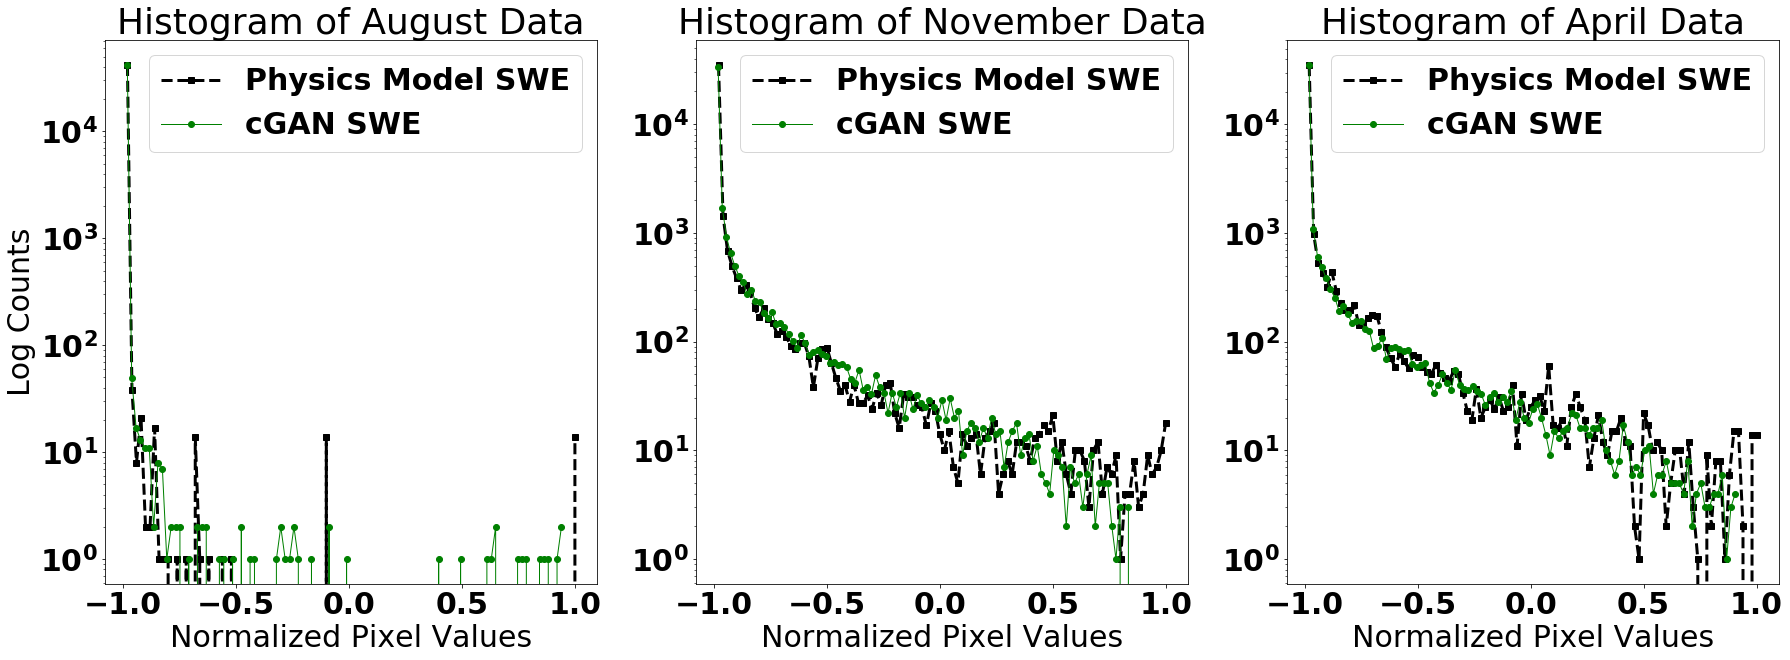

In [70]:
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 30}

plt.rc('font', **font)


nov_aug_apr_hist(data_A, data_B, mask)

In [48]:
def nov_aug_apr_hist(inputA, inputB, mask):
    starting_day = datetime.date(1900, 1, 1) + datetime.timedelta(days = 37620 + 4018 - 804)
    

    
    
    f = plt.figure(figsize=(30,40))
    f.patch.set_facecolor('white')

    gs = gridspec.GridSpec(6, 3)
    ax1 = plt.subplot(gs[0, 0])
    ax2 = plt.subplot(gs[0, 1])
    ax3 = plt.subplot(gs[0, 2])
    
    ax4 = plt.subplot(gs[1, 0])
    ax5 = plt.subplot(gs[1, 1])
    ax6 = plt.subplot(gs[1, 2])
    
    ax7 = plt.subplot(gs[2, 0:3])
    ax8 = plt.subplot(gs[3, 0:3])
    
    ax9 = plt.subplot(gs[4, 0:3])
    
    ax10 = plt.subplot(gs[5, 0:3])
    
#     ax8 = plt.subplot(gs[2, 2])
    
    
    start_date = 300
    real_hist_data, fake_hist_data =  numpy_histograms(start_date, inputA, inputB, mask, 100, False)
    ax1.plot(real_hist_data[1][1:], real_hist_data[0], linestyle = '--', c = '0.0', marker='s',  linewidth=3.0, label = 'Real Data')
    ax1.plot(fake_hist_data[1][1:], fake_hist_data[0], marker = 'o', c = 'g', linewidth = 1.0, label = 'Generated Data')
    ax1.legend(loc='upper right')
    title = "Histogram of data binned from " + str(starting_day + datetime.timedelta(days = start_date)) + " to " + str(starting_day + datetime.timedelta(days = start_date + 14))
    ax1.set_title(title)
    ax1.set_yscale('log')
    ax1.set_xlabel('Normalized Pixel Values')
    ax1.set_ylabel('Log Counts')
    
    temp = ax4.matshow(np.nan_to_num(pearson_coeff(start_date, inputA, inputB))[0,:,:], cmap='gray')
    plt.colorbar(temp, ax = ax4, boundaries=np.linspace(-1,1,101))
    ax4.set_title("Correlation Coeffs over " + str(starting_day + datetime.timedelta(days = start_date)) + " to " + str(starting_day + datetime.timedelta(days = start_date + 14)))

    
    start_date = 400
    real_hist_data, fake_hist_data =  numpy_histograms(start_date, inputA, inputB, mask, 100, False)
    ax2.plot(real_hist_data[1][1:], real_hist_data[0], linestyle = '--', c = '0.0', marker='s',  linewidth=3.0, label = 'Real Data')
    ax2.plot(fake_hist_data[1][1:], fake_hist_data[0], marker = 'o', c = 'g', linewidth = 1.0, label = 'Generated Data')
    ax2.legend(loc='upper right')
    title = "Histogram of data binned from " + str(starting_day + datetime.timedelta(days = start_date)) + " to " + str(starting_day + datetime.timedelta(days = start_date + 14))
    ax2.set_title(title)
    ax2.set_yscale('log')
    ax2.set_xlabel('Normalized Pixel Values')
    ax2.set_ylabel('Log Counts')
    
    temp = ax5.matshow(np.nan_to_num(pearson_coeff(start_date, inputA, inputB))[0,:,:], cmap = 'gray')
    plt.colorbar(temp, ax = ax5, boundaries=np.linspace(-1,1,101))
    ax5.set_title("Correlation Coeffs over "  + str(starting_day + datetime.timedelta(days = start_date)) + " to " + str(starting_day + datetime.timedelta(days = start_date + 14)))


    
    start_date = 530
    real_hist_data, fake_hist_data =  numpy_histograms(start_date, inputA, inputB, mask, 100, False)
    ax3.plot(real_hist_data[1][1:], real_hist_data[0], linestyle = '--', c = '0.0', marker='s',  linewidth=3.0, label = 'Real Data')
    ax3.plot(fake_hist_data[1][1:], fake_hist_data[0], marker = 'o', c = 'g', linewidth = 1.0, label = 'Generated Data')
    ax3.legend(loc='upper right')
    title = "Histogram of data binned from " + str(starting_day + datetime.timedelta(days = start_date)) + " to " + str(starting_day + datetime.timedelta(days = start_date + 14))
    ax3.set_title(title)
    ax3.set_yscale('log')
    ax3.set_xlabel('Normalized Pixel Values')
    ax3.set_ylabel('Log Counts')
    
    
    temp = ax6.matshow(np.nan_to_num(pearson_coeff(start_date, inputA, inputB))[0,:,:], cmap = 'gray')
    plt.colorbar(temp, ax = ax6, boundaries=np.linspace(-1,1,101))
    ax6.set_title("Correlation Coeffs over "  + str(starting_day + datetime.timedelta(days = start_date)) + " to " + str(starting_day + datetime.timedelta(days = start_date + 14)))


    
    
#     ax8.spy(mask)
#     ax8.set_title("Mask Used for ignoring irrelevant data like ocean")
    num_samples = 10
    
    sampled_input, sampled_output_real = take_n_samples_random(inputA, inputB, num_samples)
    
    sampled_input = torch.from_numpy(arr_to_input(sampled_input)[:,:,:,:])
    
    sampled_output_fake = model(sampled_input.cuda()).cpu()
    sampled_output_real = torch.from_numpy(arr_to_input(sampled_output_real))
    #print(sampled_input.shape, sampled_output_fake.shape, sampled_output_real.shape)
    
    
    img = np.hstack([image for image in sampled_input.detach().numpy().reshape(num_samples, 64*3, 64)])
    dx, dy = 64,64

    # Custom (rgb) grid color
    grid_color = 1

    # Modify the image to include the grid
    img[:,::dy] = grid_color
    img[::dx,:] = grid_color
    
    temp = ax7.imshow(img)
    plt.colorbar(temp, ax = ax7)
    ax7.set_ylabel("INPUT CHANNELS: TMIN, TMAX, PRECIPITATION")

    
    
    sampled_outputs = torch.cat((sampled_output_fake, sampled_output_real, torch.abs(sampled_output_fake - sampled_output_real)), 1)
    img = np.hstack([image for image in sampled_outputs.detach().numpy().reshape(num_samples, 64*3, 64)])

    

    # Modify the image to include the grid
    img[:,::dy] = grid_color
    img[::dx,:] = grid_color

    
    
    temp = ax8.imshow(img)
    plt.colorbar(temp, ax = ax8)
    ax8.set_ylabel("OUTPUTS: ERROR, REAL, GENERATED")
    
    
    
    
    
    
    sampled_output_fake_down = torch.from_numpy(np.array([downscale_local_mean(i[0,:,:], (2,2)) for i in sampled_output_fake.detach().numpy()]))
    sampled_output_real_down = torch.from_numpy(np.array([downscale_local_mean(i[0,:,:], (2,2)) for i in sampled_output_real.detach().numpy()]))
    
    diff = torch.abs(sampled_output_fake_down - sampled_output_real_down)
    
    sampled_outputs = torch.cat((sampled_output_fake_down, sampled_output_real_down), 1)
    img = np.hstack([image for image in sampled_outputs.detach().numpy().reshape(num_samples, 32*2, 32)])
    
    img[:,::32] = grid_color
    img[::32,:] = grid_color

    
    
    temp = ax9.imshow(img)
    plt.colorbar(temp, ax = ax9)
    ax9.set_ylabel("AVGPOOL: REAL, GENERATED")
    
    img = np.hstack([image for image in diff.numpy().reshape(num_samples, 32, 32)])
    
    img[:,::32] = grid_color
    img[::32,:] = grid_color

    
    
    temp = ax10.matshow(img, cmap='gray')
    plt.colorbar(temp, ax = ax10)
    ax10.set_ylabel("AVGPOOL: ERRORS")
    
    

In [49]:
fake_B = model(torch.from_numpy(arr_to_input(take_two_weeks(data_A, 100))[:,:,:,:]).cuda())
real_B = torch.from_numpy(arr_to_input(take_two_weeks(data_B, 100)))

In [115]:
4018 - 804

3214

In [161]:

model_output.shape

(804, 1, 64, 64)

0.065195315

0.013278133

9.542999416589737

In [112]:
import time


In [113]:
# i = 10
# sampled_in, sampled_out = take_n_samples_random(data_A, data_B, 2**i)
# start = time.clock()
# model_output = model(torch.from_numpy(arr_to_input(sampled_in)).cuda()).cpu().detach().numpy()
# print ("The model takes the following time for " + str(2**i) + " samples")
# print (time.clock() - start)

In [114]:
snotel_data = dict(np.load("snotel_values_and_index.npz"))


In [115]:
snotel_names = snotel_data['arr_0']
snotel_names

array(['Monitor Pass', 'Ward Creek #3', 'Rubicon #2',
       'Independence Creek', 'Heavenly Valley', 'Leavitt Meadows',
       'Fallen Leaf', 'Blue Lakes', 'Poison Flat', 'Squaw Valley G.C.',
       'Carson Pass', 'Lobdell Lake', 'Summit Meadow', 'Truckee #2',
       'Mt Rose Ski Area', 'Hagans Meadow', 'Big Meadow', 'Sonora Pass',
       'Burnside Lake', 'Ebbetts Pass', 'Horse Meadow', 'Leavitt Lake',
       'Virginia Lakes Ridge', 'Css Lab', 'Echo Peak', 'Marlette Lake',
       'Little Valley', 'Forestdale Creek', 'Spratt Creek',
       'Independence Lake', 'Tahoe City Cross', 'Independence Camp'],
      dtype='<U20')

In [116]:
snotel_values = snotel_data['arr_1'][:,1]
snotel_values

array([array([300, 302, 302, ...,  51,  51,  51]),
       array([485, 490, 490, ...,  81,  81,  81]),
       array([312, 318, 323, ...,  46,  46,  46]),
       array([206, 206, 203, ...,  13,  13,  13]),
       array([404, 409, 409, ...,  74,  74,  74]),
       array([211, 211, 211, ...,  38,  38,  38]),
       array([193, 193, 193, ...,  43,  43,  43]),
       array([404, 404, 404, ...,  74,  74,  74]),
       array([340, 340, 340, ...,  41,  41,  41]),
       array([897, 942, 942, ..., 112, 112, 112]),
       array([925, 925, 925, ...,  97,  97,  97]),
       array([328, 328, 328, ...,  20,  20,  20]),
       array([ 0,  0,  0, ..., 51, 51, 51]),
       array([272, 272, 272, ...,  43,  43,  43]),
       array([658, 663, 663, ...,  58,  58,  58]),
       array([282, 284, 284, ...,  41,  41,  41]),
       array([338, 338, 338, ...,  43,  43,  43]),
       array([384, 394, 404, ...,  56,  56,  56]),
       array([925, 925, 925, ...,  84,  84,  84]),
       array([508, 516, 523, ...,  94

In [117]:
snotel_indices = snotel_data['arr_1'][:,0]
snotel_indices

array([array([149, 173]), array([164, 153]), array([160, 156]),
       array([176, 151]), array([158, 163]), array([138, 174]),
       array([158, 158]), array([147, 162]), array([144, 172]),
       array([166, 151]), array([150, 160]), array([142, 180]),
       array([141, 175]), array([170, 154]), array([170, 163]),
       array([155, 162]), array([175, 162]), array([138, 173]),
       array([151, 163]), array([146, 166]), array([155, 164]),
       array([137, 172]), array([130, 185]), array([170, 148]),
       array([155, 157]), array([165, 163]), array([168, 164]),
       array([150, 161]), array([149, 166]), array([174, 150]),
       array([165, 155]), array([174, 151])], dtype=object)

In [118]:
snotel_values[2].shape

(4018,)

In [119]:
def normalize_by_peak(swe):
    return swe / np.max(swe)

In [120]:
def zero_one_norm_peak(swe):
    temp = 1 + swe
    return temp / np.max(temp)

In [121]:
def plot_station_vs_sim(index, model_output):
    plt.rcParams["figure.figsize"] = (30,10)
    #print(snotel_names[index])

    plt.plot(normalize_by_peak(snotel_values[index][3214:]), 'g')
    plt.plot(normalize_by_peak(data_B[:, int(snotel_indices[index][0]*64/321), int(snotel_indices[index][1]*64/321), 0]), 'b')
    plt.plot(zero_one_norm_peak(model_output[:, 0, int(snotel_indices[index][0]*64/321), int(snotel_indices[index][1]*64/321)]), 'r:')

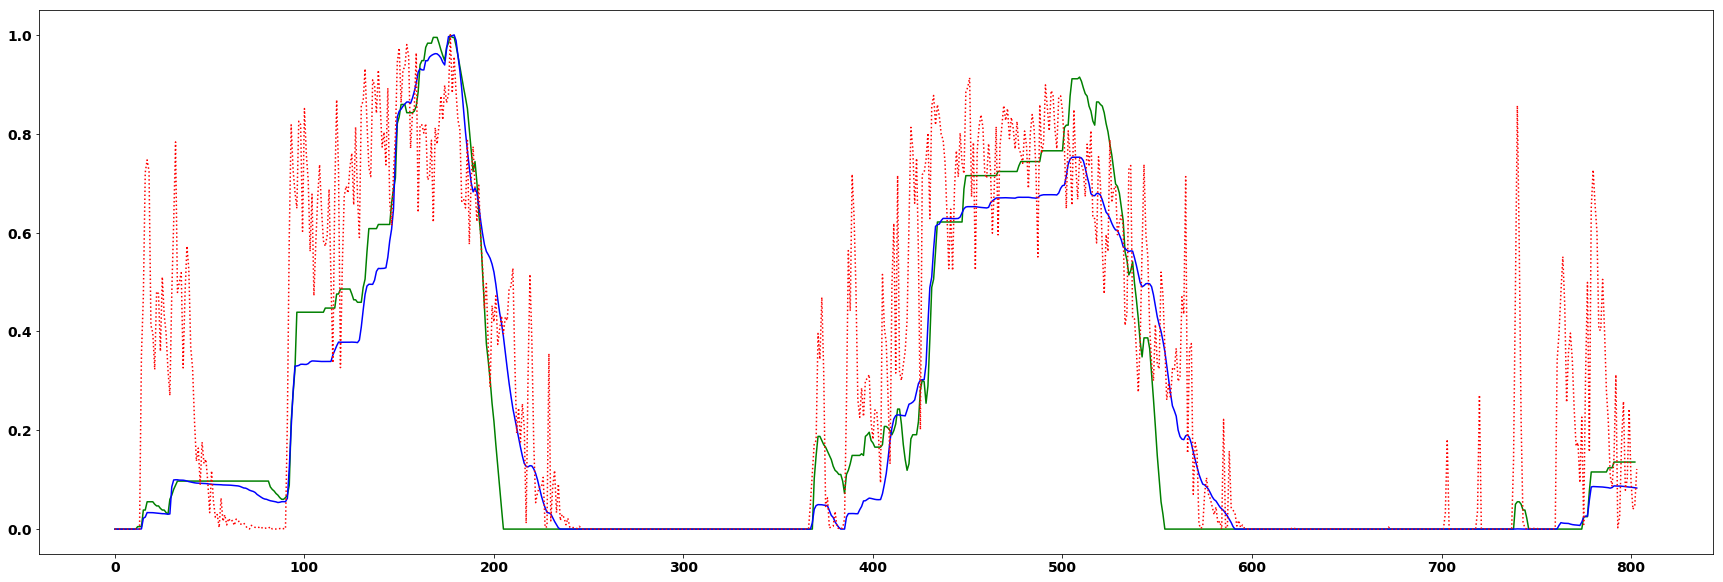

In [129]:
plot_station_vs_sim(1, model_output)

In [130]:
snotel_values[11][3214:].shape

(804,)

In [131]:
valid_snotel = []
for index in range(0, 32):
    if snotel_values[index].shape[0] == 4018:
        print(snotel_names[index], index)
        valid_snotel.append(index)

Monitor Pass 0
Rubicon #2 2
Independence Creek 3
Heavenly Valley 4
Leavitt Meadows 5
Fallen Leaf 6
Blue Lakes 7
Poison Flat 8
Squaw Valley G.C. 9
Lobdell Lake 11
Truckee #2 13
Mt Rose Ski Area 14
Hagans Meadow 15
Big Meadow 16
Sonora Pass 17
Ebbetts Pass 19
Leavitt Lake 21
Virginia Lakes Ridge 22
Css Lab 23
Echo Peak 24
Marlette Lake 25
Spratt Creek 28
Independence Lake 29
Tahoe City Cross 30
Independence Camp 31


In [132]:
valid_snotel

[0,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 11,
 13,
 14,
 15,
 16,
 17,
 19,
 21,
 22,
 23,
 24,
 25,
 28,
 29,
 30,
 31]

In [133]:
objects = snotel_names[valid_snotel]
y_pos = np.arange(len(objects))


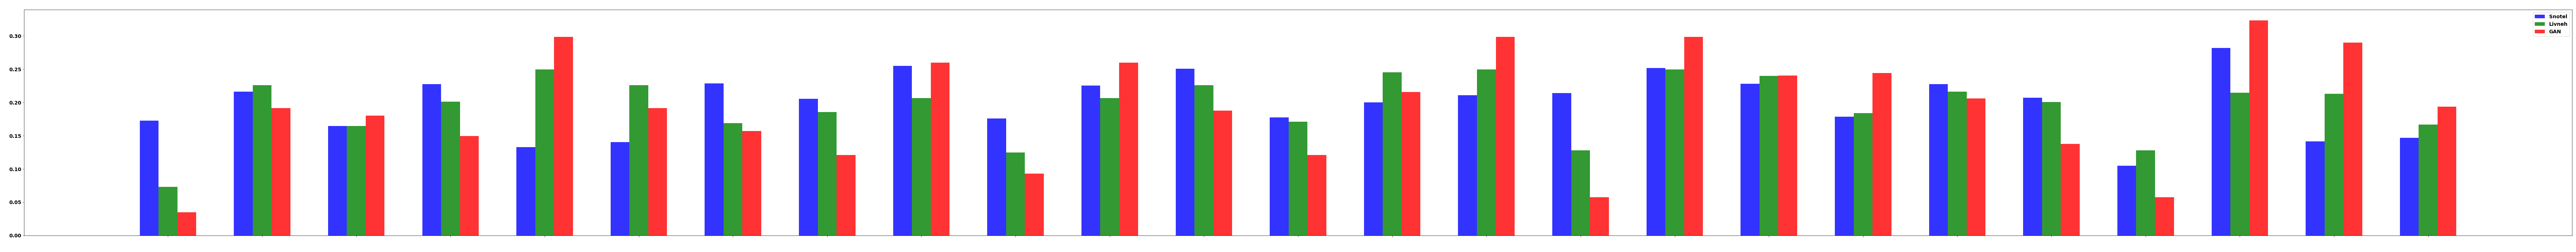

In [138]:

start_day = 0
end_day = 804
plt.rcParams["figure.figsize"] = (100,10)
plt.rcParams['axes.facecolor'] = 'white'


n_groups = len(valid_snotel)
vals_snotel = [np.mean(normalize_by_peak(snotel_values[index][3214:])[start_day:end_day]) for index in valid_snotel]
vals_livneh = [np.mean(normalize_by_peak(data_B[:, int(snotel_indices[index][0]*64/321), int(snotel_indices[index][1]*64/321), 0])[start_day:end_day]) for index in valid_snotel]
vals_gan = [np.mean(zero_one_norm_peak(model_output[:, 0, int(snotel_indices[index][0]*64/321), int(snotel_indices[index][1]*64/321)])[start_day:end_day]) for index in valid_snotel]
# create plot
fig, ax = plt.subplots()
index = np.arange(n_groups)
bar_width = 0.2
opacity = 0.8

rects1 = plt.bar(index, vals_snotel, bar_width,alpha=opacity,color='b',label='Snotel')
rects2 = plt.bar(index + bar_width, vals_livneh, bar_width,alpha=opacity,color='g',label='Livneh')
rects3 = plt.bar(index + 2*bar_width, vals_gan, bar_width,alpha=opacity,color='r',label='GAN')

plt.xlabel('Stations', color = 'white')
plt.ylabel('Normalized SWE', color = 'white')
plt.title('snotel v livneh v gan', color = 'white')
plt.xticks(index + bar_width, snotel_names[valid_snotel], color = 'white')
plt.legend()

plt.tight_layout()

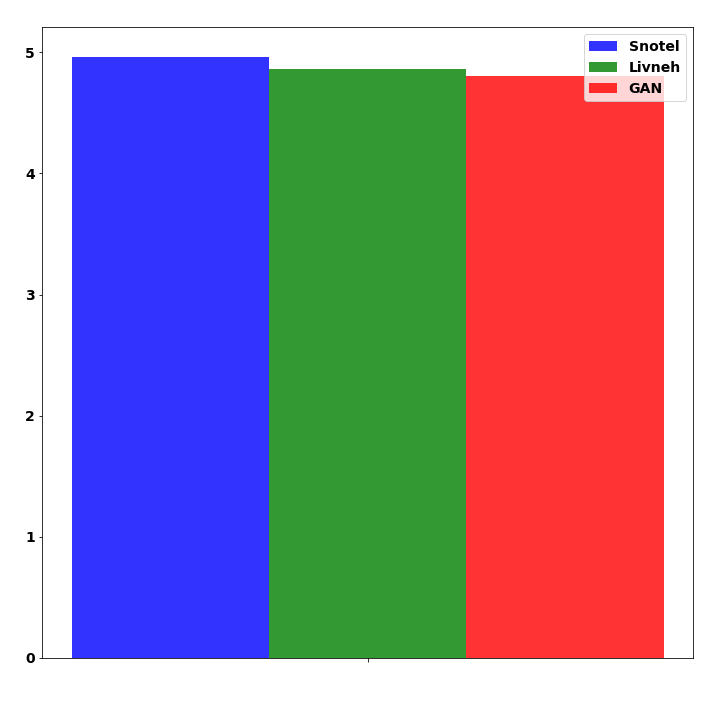

In [318]:
start_day = 0
end_day = 804
plt.rcParams["figure.figsize"] = (10,10)
plt.rcParams['axes.facecolor'] = 'white'


n_groups = 1
vals_snotel = sum([np.mean(normalize_by_peak(snotel_values[index][3214:])[start_day:end_day]) for index in valid_snotel])
vals_livneh = sum([np.mean(normalize_by_peak(data_B[:, int(snotel_indices[index][0]*64/321), int(snotel_indices[index][1]*64/321), 0])[start_day:end_day]) for index in valid_snotel])
vals_gan = sum([np.mean(zero_one_norm_peak(model_output[:, 0, int(snotel_indices[index][0]*64/321), int(snotel_indices[index][1]*64/321)])[start_day:end_day]) for index in valid_snotel])
# create plot
fig, ax = plt.subplots()
index = np.arange(n_groups)
bar_width = 0.2
opacity = 0.8

rects1 = plt.bar(index, vals_snotel, bar_width,alpha=opacity,color='b',label='Snotel')
rects2 = plt.bar(index + bar_width, vals_livneh, bar_width,alpha=opacity,color='g',label='Livneh')
rects3 = plt.bar(index + 2*bar_width, vals_gan, bar_width,alpha=opacity,color='r',label='GAN')

plt.xlabel('Stations', color = 'white')
plt.ylabel('Normalized SWE', color = 'white')
plt.title('snotel v livneh v gan', color = 'white')
plt.xticks(index + bar_width, snotel_names[valid_snotel], color = 'white')
plt.legend()

plt.tight_layout()

In [21]:
data_A.shape

(804, 64, 64, 6)

In [22]:
arr_to_input(data_A[149:150,:,:,:])[0,0:6].shape

(6, 64, 64)

In [23]:
model(torch.from_numpy(arr_to_input(data_A[149:150,:,:,:])).cuda()).cpu().detach().numpy().shape

(1, 1, 64, 64)

In [24]:
arr_to_input(data_B[149:150,:,:,:])

array([[[[-1.        , -1.        , -1.        , ..., -1.        ,
          -1.        , -1.        ],
         [-1.        , -1.        , -1.        , ..., -1.        ,
          -1.        , -1.        ],
         [-1.        , -1.        , -1.        , ..., -1.        ,
          -1.        , -1.        ],
         ...,
         [-1.        , -1.        , -1.        , ..., -0.18866579,
          -1.        , -1.        ],
         [-1.        , -1.        , -1.        , ..., -0.31122586,
          -1.        , -1.        ],
         [-1.        , -1.        , -1.        , ..., -0.16582628,
          -1.        , -1.        ]]]], dtype=float32)

In [73]:
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 17}

plt.rc('font', **font)


In [111]:
starting_day = datetime.date(1900, 1, 1) + datetime.timedelta(days = 37620 + 4018 - 804)
str(starting_day + datetime.timedelta(days = 1)) 

'2011-10-21 to 2011-11-04'

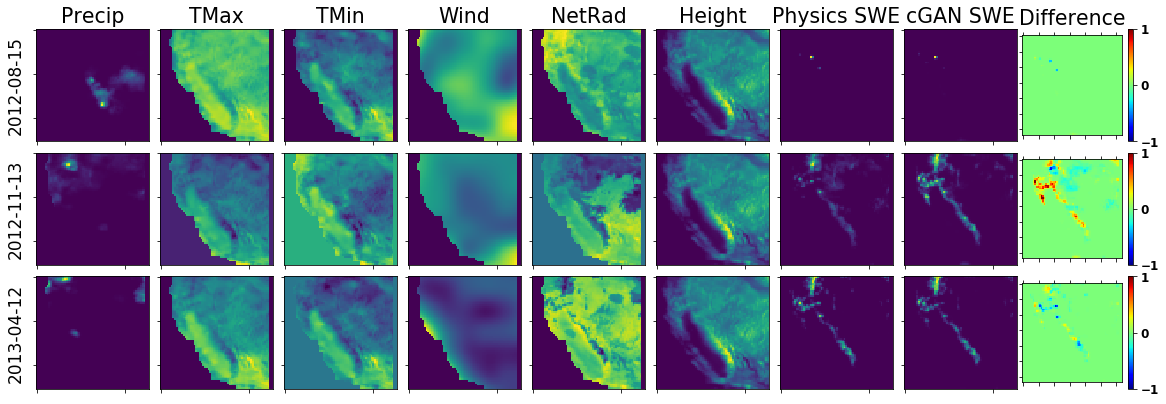

In [121]:
f = plt.figure(figsize=(20,10))
f.patch.set_facecolor('white')

gs = gridspec.GridSpec(3, 9, wspace=0, hspace=0.1, top=0.5, bottom=0.0)
plt.tight_layout()
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False)
days = [300, 390, 540]

for row in range(0, 3):

    font = {'family' : 'normal',
            'weight' : 'bold',
            'size'   : 17}

    plt.rc('font', **font)
    ind = days[row]
    inp_dat = arr_to_input(data_A[ind:ind+1, :,:,:])[0,0:6]
    true_SWE = arr_to_input(data_B[ind:ind+1,:,:,:])[0,0,:,:]
    fake_SWE = model(torch.from_numpy(arr_to_input(data_A[ind:ind+1,:,:,:])).cuda()).cpu().detach().numpy()[0,0,:,:]
    temp = plt.subplot(gs[row, 0])
    temp.set_ylabel(str(starting_day + datetime.timedelta(days = int(ind))) )
    
    for col in range(0, 6):
            
        temp = plt.subplot(gs[row, col])
        temp.get_xaxis().set_ticklabels([])
        temp.get_yaxis().set_ticklabels([])
        #temp.axis('off')
        val = inp_dat[col, :, :]
        temp.imshow(np.flip(val, 0))
    
    temp = plt.subplot(gs[row, 6])
    #temp.axis('off')
    temp.get_xaxis().set_ticklabels([])
    temp.get_yaxis().set_ticklabels([])
    temp.imshow(np.flip(true_SWE, 0))
    
    temp = plt.subplot(gs[row, 7])
    #temp.axis('off')
    temp.get_xaxis().set_ticklabels([])
    temp.get_yaxis().set_ticklabels([])
    temp.imshow(np.flip(fake_SWE, 0))
    
    temp = plt.subplot(gs[row, 8])
    #temp.axis('off')
    temp.get_xaxis().set_ticklabels([])
    temp.get_yaxis().set_ticklabels([])
    temp_im = temp.matshow(np.flip(fake_SWE - true_SWE, 0), vmin=-1, vmax=1, cmap = 'jet')
    
    font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 12}

    plt.rc('font', **font)

    plt.colorbar(temp_im, ax = temp, cmap='jet')

    
    
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 17}

plt.rc('font', **font)


labels = ["Precip", "TMax", "TMin", "Wind", "NetRad", "Height", "Physics SWE", "cGAN SWE", "Difference"]
for col in range(0, 9):
    plt.subplot(gs[0, col]).set_title(labels[col])
    


In [119]:
import matplotlib.pyplot as pltstarting_day = datetime.date(1900, 1, 1) + datetime.timedelta(days = 37620 + 4018 - 804)

SyntaxError: invalid syntax (<ipython-input-119-c64304574161>, line 1)

In [81]:
test_data_input['variables']

array(['Prec', 'Tmax', 'Tmin', 'Wind', 'NetRad', 'Height'], dtype='<U6')

NameError: name 'start_date' is not defined